In [1]:
# Hypothesis: smaller kernel sizes will lead to higher accuracies of classification in fined-tuned image classification
# We think this is likely due to the ability of the CNN to detect smaller features between relatively similar images of the same species
# Independent Variables: kernel size
# Constant Variables: number of layers, types of layers, input shape, epoches, hyperparamaters(depth,padding)
# Dependent Variables: Accuracy
# Limitations: we are foregoing pure accuracy for experimental reasons - we could get higher accuracy if we tried but we're keeping
# things constant for consistancy between models
# Currently only using Input, Convolutional, Relu, Pool, and FC/Dense layers. Can add Dense and Dropout if we have time
# Reference to www.cs231n.github.io/convolutional-networks

In [2]:
# 3. Import libraries and modules
import os, cv2, argparse
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.applications.xception import Xception
from keras.preprocessing.image import ImageDataGenerator
from numpy.random import RandomState
np.random.seed(123)  # for reproducibility
import sys
import random

/home/cfu288/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
def shuffle_data(arr1, arr2):
    seed = random.randint(0, 1000)
    ran = RandomState(seed)
    ran.shuffle(arr1)
    ran = RandomState(seed)
    ran.shuffle(arr2)

In [3]:
# INPUT
TRAIN_DIR = './training/'
TEST_DIR = './validation/'
EPOCHS = 10
HEIGHT = 150
WIDTH = 150

In [11]:
# Setup, Read in images, Preprocess images for training
TRAIN_IMG, TRAIN_CLS, TEST_IMG, TEST_CLS = ([] for i in range(4))
COLS = ['Label', 'Latin Name', 'Common Name', 'Train Images', 'Validation Images']
LABELS = pd.read_csv('./monkey_labels.txt', names=COLS, skiprows=1)
CLASSES = [x for x in range(0, len(LABELS))]

# read in all images
# resizing the images to 100x100 to make training faster
print("READING IN AND FORMATTING IMAGES")
for x in range(0, len(LABELS)):
    train_dir = TRAIN_DIR + LABELS.loc[x,'Label'].strip() + '/'
    test_dir = TEST_DIR + LABELS.loc[x,'Label'].strip() + '/'
    for file in os.listdir(train_dir):
        img = cv2.imread(train_dir + file)
        if img is not None:
            img = cv2.resize(img, (150, 150))
            TRAIN_IMG.append(img)
            TRAIN_CLS.append(x)
    for file in os.listdir(test_dir):
        img = cv2.imread(test_dir + file)
        if img is not None:
            img = cv2.resize(img, (150, 150))
            TEST_IMG.append(img)
            TEST_CLS.append(x)
print("DONE")

READING IN AND FORMATTING IMAGES
DONE


(1098, 150, 150, 3)


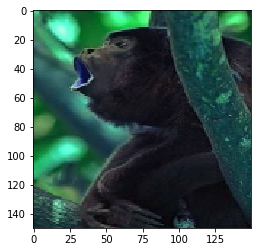

In [12]:
# convert to numpy arrays
TRAIN_IMG = np.array(TRAIN_IMG)
TEST_IMG = np.array(TEST_IMG)
TRAIN_CLS = np.array(TRAIN_CLS)
TEST_CLS = np.array(TEST_CLS)

print(TRAIN_IMG.shape)
plt.imshow(TRAIN_IMG[0])

# Preprocess images
# Reshape them to theanos format (channels, hight, width) # changed to tensorflow
# Convert to 0-255 to value in [0-1]
TRAIN_IMG = TRAIN_IMG.reshape(TRAIN_IMG.shape[0], 150, 150, 3)
TEST_IMG = TEST_IMG.reshape(TEST_IMG.shape[0], 150, 150, 3)
TRAIN_IMG = TRAIN_IMG.astype('float32')
TEST_IMG = TEST_IMG.astype('float32')
TRAIN_IMG /= 255
TEST_IMG /= 255

# Reshape class labels
TRAIN_CLS = np_utils.to_categorical(TRAIN_CLS, 10)
TEST_CLS = np_utils.to_categorical(TEST_CLS, 10)

# Shuffle the data
shuffle_data(TRAIN_IMG, TRAIN_CLS)
shuffle_data(TEST_IMG, TEST_CLS)

In [12]:
TRAIN_DATAGEN = ImageDataGenerator(rescale=1./255,
                                   rotation_range=25, 
                                   horizontal_flip=0.5, 
                                   zoom_range=0.1, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2,
                                   fill_mode='nearest'
                                  )

TEST_DATAGEN = ImageDataGenerator(rescale=1./255)

TRAIN_GENERATOR = TRAIN_DATAGEN.flow_from_directory(
        TRAIN_DIR,  # this is the target directory
        target_size=(150, 150),  # all images will be resized to 150x150
        batch_size=32,
        class_mode='categorical')
print(TRAIN_GENERATOR.class_indices)

TEST_GENERATOR = TEST_DATAGEN.flow_from_directory(
        TEST_DIR,  # this is the target directory
        target_size=(150, 150),  # all images will be resized to 150x150
        batch_size=32,
        class_mode='categorical')

print(TEST_GENERATOR.class_indices)

Found 1097 images belonging to 10 classes.
{'n0': 0, 'n1': 1, 'n2': 2, 'n3': 3, 'n4': 4, 'n5': 5, 'n6': 6, 'n7': 7, 'n8': 8, 'n9': 9}
Found 272 images belonging to 10 classes.
{'n0': 0, 'n1': 1, 'n2': 2, 'n3': 3, 'n4': 4, 'n5': 5, 'n6': 6, 'n7': 7, 'n8': 8, 'n9': 9}


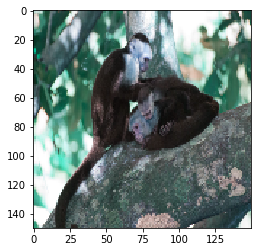

In [13]:
# Print some of the input for display
plt.imshow(TRAIN_IMG[0])

In [27]:
''' Why CNN over NN?
    Regular FC NN don't scale well to images - too many weights and too connected - leads to over fitting and long
    compute times
    Instead of connecting densely like a NN, a CNN layer only connects the neurons in a layer to a small region of 
    the layer before it. Also allows for reducing the image to a single vector in the end.
'''

''' What is a Convolutional layer?
    A convolutional layer is a 3D layer (vs a 1D layer in a dense) where the depth of the layer is the number of
    learnable filters. A filter is a set of weights inna 3d matrix that transveres over the input image. Each filter 
    is small spatially (width and height wise), but extend the depth of the input (so 3 for our case). A typical 
    filter may be [5x5x3] - 5 pixels wide and high, 3 deep. During the forward pass, we slide(convolve) each filter 
    across the width and height of the input and compute dot products between the filter and the input.
'''

''' What do these filters do?
    As we slide these filters across the input image, we build a 2d activation map that gives the responses of that
    specific filter at each point in the image. What this means is that the filters scan the input for "features" 
    like edges or areas of high contrast, and the filter will be "activated" when it passes its "feature" on the 
    input image. We can see where in the image a feature was found by seeing where on the the 2d activation 
    map is activated for the filter that is detecting that feature. Convolutional layers deeper in the 
    architecture might be able to detect more complex attributes in the image like patterns, small objects(eyes, 
    wheels), etc.
'''

''' How big is the volume of a Convolutional layer (Height,Width,Depth) given:
    INPUT_SIZE(W), FILTER_SIZE(F), NUM_OF_FILTERS, STRIDE(S), PADDING(P)
      Padding - It is a HYPERPARAMATER. Pad the input volume with zeros around the border. Generally used to control the
        spacial size of the output volumes, usually to match size size of the input volume.
      Stride - amount of pixels we shift each filter by when scanning. Stride of 1 means we move filters one pixel 
        at a time. Larger strides lead to a smaller output volume in the layer
      Depth - It is a HYPERPARAMATER. It corresponds to the number of filters we want to use. Each filter looks for 
        something different in input. 
    Volume = (W−F+2P)/S+1 
    Our CNN has an input of 100x100, filter of 3x3, no padding, stride of 1, 110 number of filters. 
    (100-3) + 1 = 98, so the output layer contains 98x98x110 neurons.
'''

''' What does this mean for our Convolutional layer?
    Each neuron from the [98x98x110] output volume is attached to a [3x3x3] filter in the input volume.
    All the neurons in the same area in the depth column (so 110 of them) actually map to the exact same
    filter on the input, but each should have different numerical outputs since each filter is looking for a 
    different feature
'''

' What does this mean for our Convolutional layer?\n    Each neuron from the [98x98x110] output volume is attached to a [3x3x3] filter in the input volume.\n    All the neurons in the same area in the depth column (so 110 of them) actually map to the exact same\n    filter on the input, but each should have different numerical outputs since each filter is looking for a \n    different feature\n'

In [16]:
base_model = Xception(include_top=False, weights='imagenet', input_shape=(150, 150, 3))

# Freeze the layers 
for layer in base_model.layers:
    layer.trainable = False

# Add custom model at the end
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation='relu', input_dim=5*5*2048))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

# Print the layers in the model
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Number of samples processed per epoch is steps_per_epoch * batch_size
history = model.fit_generator(TRAIN_GENERATOR, steps_per_epoch=34, epochs=10, verbose=1, shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 5, 5, 2048)        20861480  
_________________________________________________________________
flatten_1 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               26214912  
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 10)                5130      
Total params: 47,081,522
Trainable params: 26,220,042
Non-trainable params: 20,861,480
_________________________________________________________________
Epoch 1/10
34/34 [==============================] - 170s 5s/step - loss: 9.8157 - acc: 0.2230
Epoch 2/10
34/34 [=========

In [27]:
#model = load_model('models/xception-150x150-10e.h5')

#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#history = model.fit(TRAIN_IMG, TRAIN_CLS, batch_size=32, epochs=EPOCHS+5, 
                    #initial_epoch=EPOCHS, validation_split=0.1, verbose=1, shuffle=True)
    


model.fit_generator(TRAIN_GENERATOR, steps_per_epoch=34, epochs=40, initial_epoch=30, verbose=1, shuffle=True)

Epoch 31/40
34/34 [==============================] - 164s 5s/step - loss: 0.8329 - acc: 0.7209
Epoch 32/40
34/34 [==============================] - 148s 4s/step - loss: 0.8783 - acc: 0.7223
Epoch 33/40
34/34 [==============================] - 109s 3s/step - loss: 0.8442 - acc: 0.7407
Epoch 34/40
34/34 [==============================] - 171s 5s/step - loss: 0.7983 - acc: 0.7485
Epoch 35/40
34/34 [==============================] - 160s 5s/step - loss: 0.7683 - acc: 0.7389
Epoch 36/40
34/34 [==============================] - 166s 5s/step - loss: 0.8284 - acc: 0.7196
Epoch 37/40
34/34 [==============================] - 160s 5s/step - loss: 0.8507 - acc: 0.7287
Epoch 38/40
34/34 [==============================] - 161s 5s/step - loss: 0.8909 - acc: 0.7113
Epoch 39/40
34/34 [==============================] - 167s 5s/step - loss: 0.7288 - acc: 0.7734
Epoch 40/40
34/34 [==============================] - 161s 5s/step - loss: 0.8418 - acc: 0.7260


In [29]:
# Save the model
print("SAVE MODEL")
model.save('models/xception-150x150-40e-generator.h5')
print(history.history.keys())

SAVE MODEL
dict_keys(['loss', 'acc'])


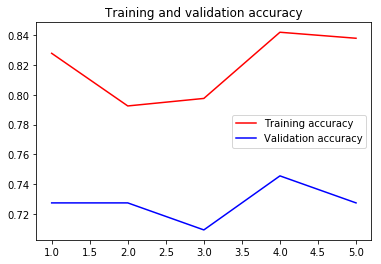

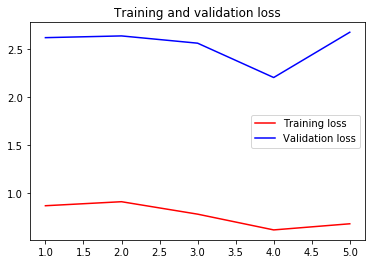

In [14]:
# Print a plot of loss and accuracy over epochs
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training accuracy')
plt.plot(epochs, val_acc, 'blue', label='Validation accuracy')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()


In [28]:
#model = load_model('test_model.h5')

# Evaluate the model on the validation data
loss, acc = model.evaluate_generator(TEST_GENERATOR, 272/32)
print("Loss: ", loss, " Accuracy: ", acc)

Loss:  0.6873359503772329  Accuracy:  0.8823529411764706


In [ ]:
# Predict images
# TODO - Print mispredicted images, the label it predicted, and the correct label
'''
for i in range(len(TEST_IMG)):
    img = TEST_IMG[i]
    cls = TEST_CLS[i]
    img = np.array([img])
    prediction = model.predict(img, verbose=1, steps=1)
    print
    print "Class: ", cls
    print "Prediction: ", prediction[0]
    max_index = np.argmax(prediction[0])
    print "Predicted Class index: ", max_index
    print "Prediction Correct: ", True if cls[max_index] == 1. else False
'''